# Visualisation of layers

In [10]:
import pickle
import torch
import matplotlib.pyplot as plt
import src._init_paths
from src.lib.networks import resnet, densenet, normal
import cv2
import numpy as np

In [11]:
f = open('data/supervised/chars_50.pkl', 'rb')
data = pickle.load(f)
f.close()

train = data[0]

In [12]:
class SaveFeatures():
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = torch.tensor(output,requires_grad=True)
    def __remove__(self):
        self.hook.remove()

In [90]:
class FilterVisualizer():
    def __init__(self, model, block, iblock, size=56, upscaling_steps=12, upscaling_factor=1.2):
        self.size, self.upscaling_steps, self.upscaling_factor = size, upscaling_steps, upscaling_factor
        self.model = model
        self.model.eval()
        self.block = block
        self.iblock = iblock

    def visualize(self, channel, lr=1e-2, opt_steps=10, blur=None):
        sz = self.size
#         img = np.uint8(np.random.uniform(10, 30, (sz, sz)))/255  # generate random image
        img = train[8,8].reshape(32, 32)
        activations = SaveFeatures(list(self.model.children())[0][self.block][self.iblock][0])  # register hook

        for _ in range(self.upscaling_steps):  # scale the image up upscaling_steps times
            img_var = torch.tensor(img, dtype=torch.float32).view(-1, 1, *img.shape).requires_grad_()
            optimizer = torch.optim.AdamW([img_var], lr=lr)
            for n in range(opt_steps):  # optimize pixel values for opt_steps times
                optimizer.zero_grad()
                self.model(img_var)
                loss = -activations.features[0, channel].mean()
                print('Step: {step}; loss: {loss:}'.format(step=_, loss=loss.item()), end='\r')
                loss.backward()
                optimizer.step()
            self.output = img
            sz = int(self.upscaling_factor * sz)  # calculate new image size
            img = cv2.resize(img, (sz, sz), interpolation = cv2.INTER_CUBIC)  # scale image up
            if blur is not None: img = cv2.blur(img,(blur,blur))  # blur image to reduce high frequency patterns
        self.show()
        
    def show(self):
        plt.figure(figsize=(7,7))
        plt.imshow(np.clip(self.output, 0, 1))

In [91]:
model = resnet.Telnet()
model.load_state_dict(torch.load('Logs/fine-test/tuned/1/resnet/30/model.pth'))

<All keys matched successfully>

In [92]:
list(model.children())[0][3][0]

Sequential(
  (0): Conv2d(32, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
)

/Users/knight/.pyenv/versions/torch/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


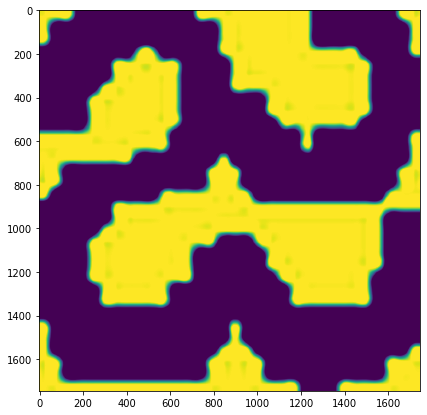

In [94]:
FV = FilterVisualizer(model, 0, 0, size=56, upscaling_steps=20)
FV.visualize(4, blur=1)